In [64]:
import os
import random
import shutil
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

In [57]:
close_eyes_path = "/kaggle/input/driver-drowsiness/Data_Set/Close-Eyes"
open_eyes_path = "/kaggle/input/driver-drowsiness/Data_Set/Open-Eyes"

In [11]:
def count_images_in_folder(folder_path):
    return len([file for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))])

num_close_eyes = count_images_in_folder(close_eyes_path)
num_open_eyes = count_images_in_folder(open_eyes_path)

print(f"Nombre d'images dans 'Close-Eyes': {num_close_eyes}")
print(f"Nombre d'images dans 'Open-Eyes': {num_open_eyes}")

Nombre d'images dans 'Close-Eyes': 41946
Nombre d'images dans 'Open-Eyes': 42952


In [12]:
output_dir = "/kaggle/working/dataset_split"

if os.path.exists(output_dir):
    shutil.rmtree(output_dir)

for subset in ['train', 'valid', 'test']:
    for category in ['Close-Eyes', 'Open-Eyes']:
        os.makedirs(os.path.join(output_dir, subset, category), exist_ok=True)

def split_files(input_dir, output_dir, train_ratio=0.6, valid_ratio=0.3, test_ratio=0.1):

    files = os.listdir(input_dir)
    files = [f for f in files if os.path.isfile(os.path.join(input_dir, f))]

    random.shuffle(files)

    total_files = len(files)
    train_end = int(total_files * train_ratio)
    valid_end = train_end + int(total_files * valid_ratio)

    train_files = files[:train_end]
    valid_files = files[train_end:valid_end]
    test_files = files[valid_end:]

    for file_list, subset in zip([train_files, valid_files, test_files], ['train', 'valid', 'test']):
        for f in file_list:
            src = os.path.join(input_dir, f)
            category = os.path.basename(input_dir)
            dst = os.path.join(output_dir, subset, category, f)
            shutil.copy(src, dst)

split_files(close_eyes_path, output_dir)
split_files(open_eyes_path, output_dir)

In [13]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [14]:
train_dir = r"/kaggle/working/dataset_split/train"
val_dir = r"/kaggle/working/dataset_split/valid"
test_dir = r"/kaggle/working/dataset_split/test"

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 50938 images belonging to 2 classes.
Found 25468 images belonging to 2 classes.
Found 8492 images belonging to 2 classes.


In [15]:
images, labels = train_generator[0]
print("Shape des images train:", images.shape)
print("Shape des labels train:", labels.shape)

Shape des images train: (32, 64, 64, 3)
Shape des labels train: (32,)


In [16]:
images, labels = val_generator[0]
print("Shape des images valid:", images.shape)
print("Shape des labels valid:", labels.shape)

Shape des images valid: (32, 64, 64, 3)
Shape des labels valid: (32,)


In [17]:
images, labels = test_generator[0]
print("Shape des images test:", images.shape)
print("Shape des labels test:", labels.shape)

Shape des images test: (32, 64, 64, 3)
Shape des labels test: (32,)


In [18]:
def plot_class_distribution(generator, title):
    
    labels = generator.classes
    class_counts = Counter(labels)
    class_names = list(generator.class_indices.keys())
    
    counts = [class_counts[i] for i in range(len(class_names))]
    
    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")
    
    palette = sns.color_palette("gray", len(class_names))
    ax = sns.barplot(x=class_names, y=counts, palette=palette)
    
    for i, count in enumerate(counts):
        ax.text(i, count / 2, str(count), ha='center', va='center', fontsize=12, color='white', fontweight='bold')
    
    plt.title(title, fontsize=16)
    plt.xlabel('Class', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


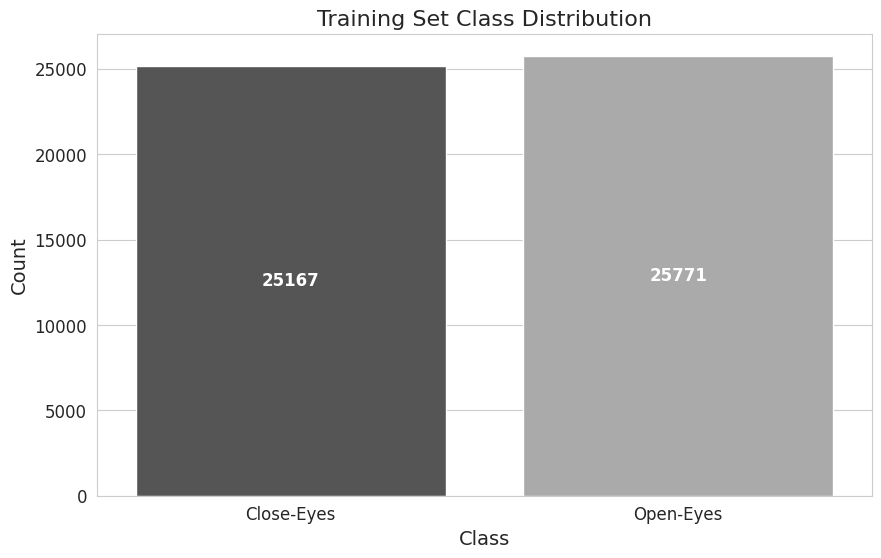

In [19]:
plot_class_distribution(train_generator, 'Training Set Class Distribution')
# 0 --> Close-Eyes 1 --> Open-Eyes

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


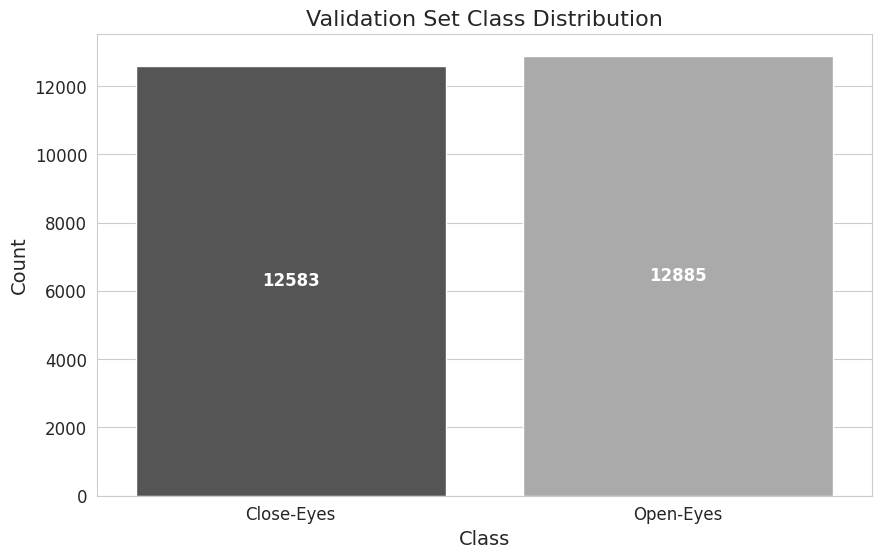

In [20]:
plot_class_distribution(val_generator, 'Validation Set Class Distribution')

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


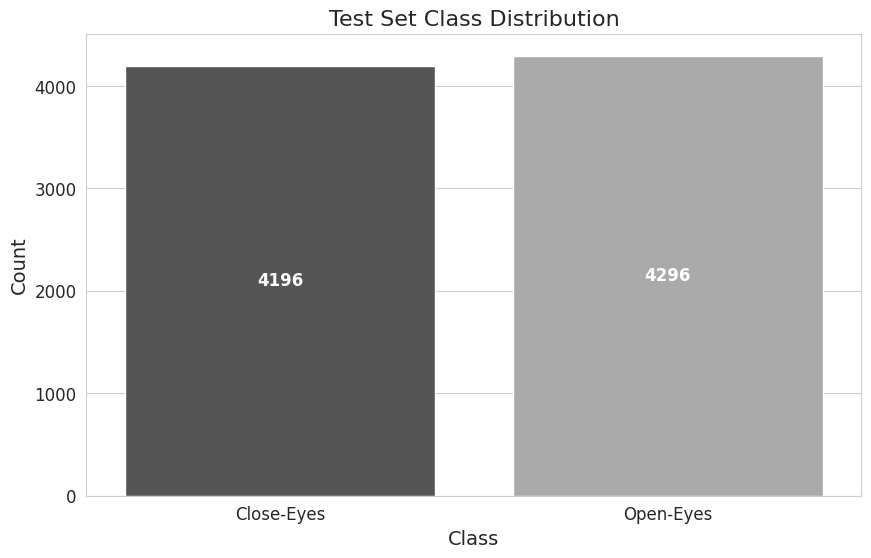

In [21]:
plot_class_distribution(test_generator, 'Test Set Class Distribution')

In [22]:
def plot_sample_images(folder_path, title):
    
    image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    
    if len(image_files) == 0:
        print(f"Aucune image trouvée dans le dossier : {folder_path}")
        return
    
    sample_images = random.sample(image_files, min(5, len(image_files)))
    
    plt.figure(figsize=(15, 5))
    for i, image_file in enumerate(sample_images):
        
        image_path = os.path.join(folder_path, image_file)
        img = Image.open(image_path)
        
        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.title(f"Image {i + 1}")
        plt.axis('off')
    
    plt.suptitle(title, fontsize=16)
    plt.show()

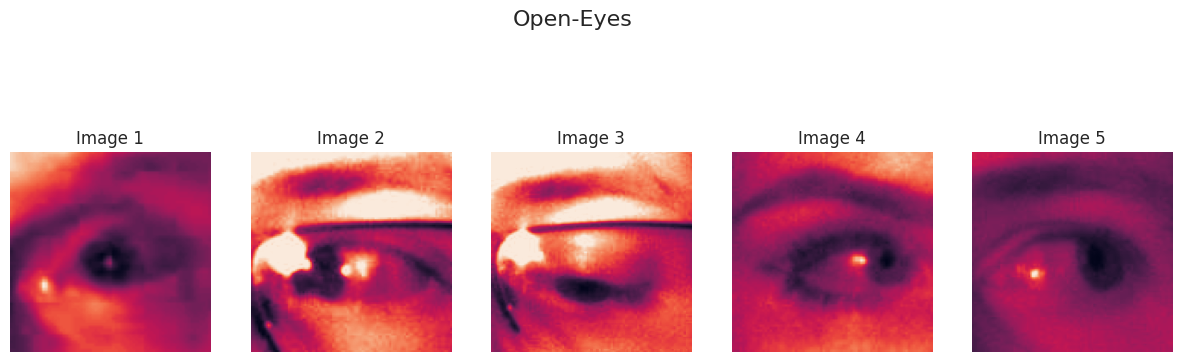

In [23]:
plot_sample_images(open_eyes_path, "Open-Eyes")

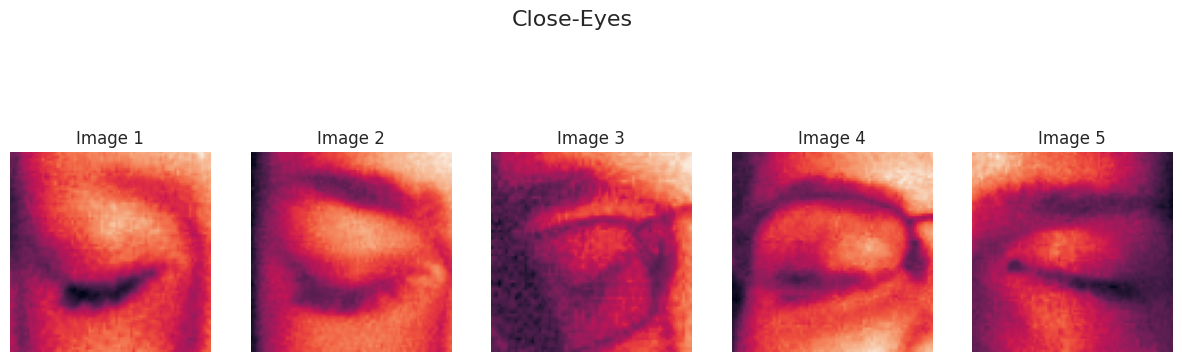

In [24]:
plot_sample_images(close_eyes_path, "Close-Eyes")

In [31]:
def accuracy(y_true, y_pred):
    
    y_pred_classes = (y_pred > 0.5).astype("int32")  # Convertir probabilités en classes
    correct_predictions = np.sum(y_true == y_pred_classes)
    accuracy_value = correct_predictions / len(y_true) * 100
    return accuracy_value

def precision(y_true, y_pred, positive_class=1):

    y_pred_classes = (y_pred > 0.5).astype("int32")  # Convertir probabilités en classes
    true_positive = np.sum((y_true == positive_class) & (y_pred_classes == positive_class))
    predicted_positive = np.sum(y_pred_classes == positive_class)
    precision_value = true_positive / predicted_positive if predicted_positive != 0 else 0
    return precision_value

def recall(y_true, y_pred, positive_class=1):

    y_pred_classes = (y_pred > 0.5).astype("int32")  # Convertir probabilités en classes
    true_positive = np.sum((y_true == positive_class) & (y_pred_classes == positive_class))
    actual_positive = np.sum(y_true == positive_class)
    recall_value = true_positive / actual_positive if actual_positive != 0 else 0
    return recall_value

def f1_score(y_true, y_pred, positive_class=1):

    precision_value = precision(y_true, y_pred, positive_class)
    recall_value = recall(y_true, y_pred, positive_class)
    f1_score_value = 2 * (precision_value * recall_value) / (precision_value + recall_value) if (precision_value + recall_value) != 0 else 0
    return f1_score_value

In [32]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [33]:
checkpoint_path_Alex = '/kaggle/working/AlexNet.keras'
checkpoint_path_Vgg = '/kaggle/working/VggNet.keras'
checkpoint_path_Res = '/kaggle/working/ResNet.keras'
checkpoint_path_CnnP = '/kaggle/working/CnnParallel.keras'

In [34]:
def train_model(model, train_images, val_images, epochs=20):

    all_training_loss = []
    all_val_loss = []
    all_training_acc = []
    all_val_acc = []
    
    for epoch in range(1, epochs + 1):
        print(f"Epoch {epoch}/{epochs}")
        try:
       
            history = model.fit(
                train_images,
                steps_per_epoch=len(train_images),
                validation_data=val_images,
                validation_steps=len(val_images),
                epochs=1,
                callbacks=[
                    reduce_lr,
                    early_stopping,
                    checkpoint_callback
                ]
            )
            
            all_training_loss.append(history.history['loss'][0])
            all_val_loss.append(history.history['val_loss'][0])
            all_training_acc.append(history.history['accuracy'][0])
            all_val_acc.append(history.history['val_accuracy'][0])

        except StopIteration:
            continue

        except Exception as e:
            print(f"Une erreur s'est produite pendant l'époque {epoch}: {e}")
            break

        if early_stopping.stopped_epoch > 0:
            print("L'entraînement a été interrompu en raison de l'arrêt précoce.")
            break

    print("L'entraînement s'est terminé.")
    
    return {
        "training_loss": all_training_loss,
        "val_loss": all_val_loss,
        "training_accuracy": all_training_acc,
        "val_accuracy": all_val_acc
    }

## **ALEX_NET**

In [35]:
def AlexNet(img_width=64, img_height=64):
    inp = layers.Input((img_width, img_height, 3))
    
    # 1er Bloc de Convolution
    x = layers.Conv2D(96, kernel_size=11, strides=4, activation='relu')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2)(x)  # Sortie : (14, 14, 96)
    
    # 2ème Bloc de Convolution
    x = layers.Conv2D(256, kernel_size=5, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2)(x)  # Sortie : (6, 6, 256)
    
    # 3ème Bloc de Convolution
    x = layers.Conv2D(384, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv2D(384, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
    # Modification ici : pool_size=2 pour éviter l'erreur
    x = layers.MaxPooling2D(pool_size=2, strides=2)(x)  # Sortie : (3, 3, 256)
    
    # Couches fully connected
    x = layers.Flatten()(x)  # Sortie : 3*3*256 = 2304
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    # Couche de sortie
    x = layers.Dense(1, activation='sigmoid')(x)  # Pour classification binaire
    
    # Création du modèle
    model = models.Model(inputs=inp, outputs=x)
    return model

model_Alex = AlexNet(img_width=64, img_height=64)
model_Alex.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 14, 14, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 14, 14, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 6, 6, 96)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 6, 6, 256)           │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 6, 6, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 2, 2, 384)           │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 2, 2, 384)           │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 2, 2, 256)           │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │       1,052,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │           4,097 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,586,689 (82.35 MB)

 Trainable params: 21,585,985 (82.34 MB)

 Non-trainable params: 704 (2.75 KB)

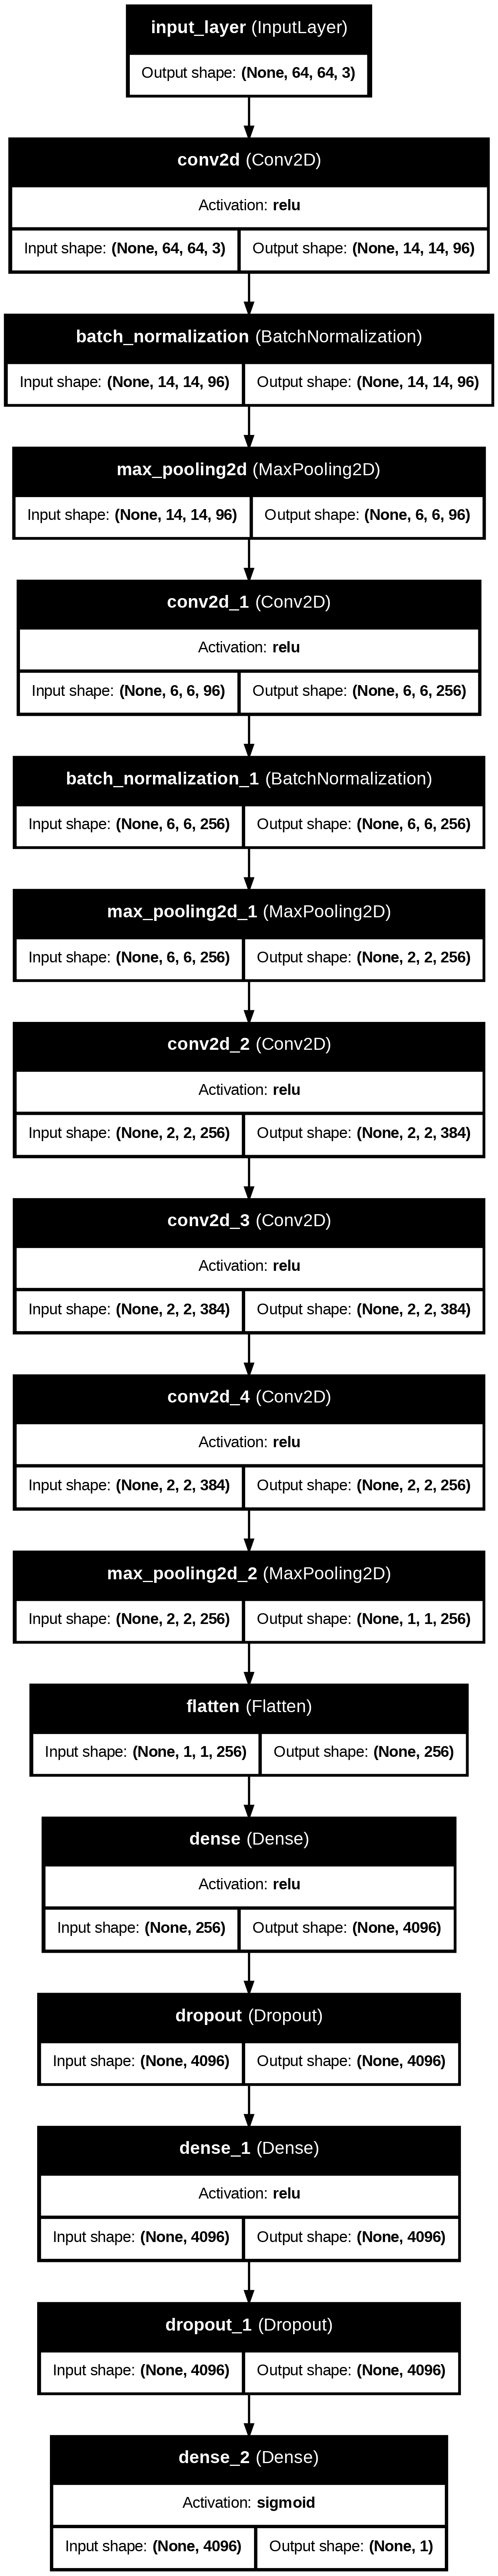

In [36]:
tf.keras.utils.plot_model(
    model_Alex,
    to_file='alex_model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    show_layer_activations=True,
    dpi=200
)

In [39]:
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path_Alex,
    save_weights_only=False,
    monitor="val_accuracy",
    save_best_only=True,
)

In [41]:
if __name__ == "__main__":


    model_Alex.compile(
        optimizer=Adam(0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    history_data = train_model(model_Alex, train_generator, val_generator, epochs=10)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1592/1592 ━━━━━━━━━━━━━━━━━━━━ 118s 68ms/step - accuracy: 0.8388 - loss: 0.3457 - val_accuracy: 0.9430 - val_loss: 0.1866 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 1.
Epoch 2/10
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 101s 63ms/step - accuracy: 0.9342 - loss: 0.1632 - val_accuracy: 0.8268 - val_loss: 0.3574 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 1.
Epoch 3/10
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 102s 64ms/step - accuracy: 0.9470 - loss: 0.1345 - val_accuracy: 0.9498 - val_loss: 0.1368 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 1.
Epoch 4/10
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 101s 63ms/step - accuracy: 0.9531 - loss: 0.1178 - val_accuracy: 0.9377 - val_loss: 0.1471 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 1.
Epoch 5/10
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 101s 63ms/step - accuracy: 0.9571 - loss: 0.1104 - val_accuracy: 0.8493 - val_loss: 0.345

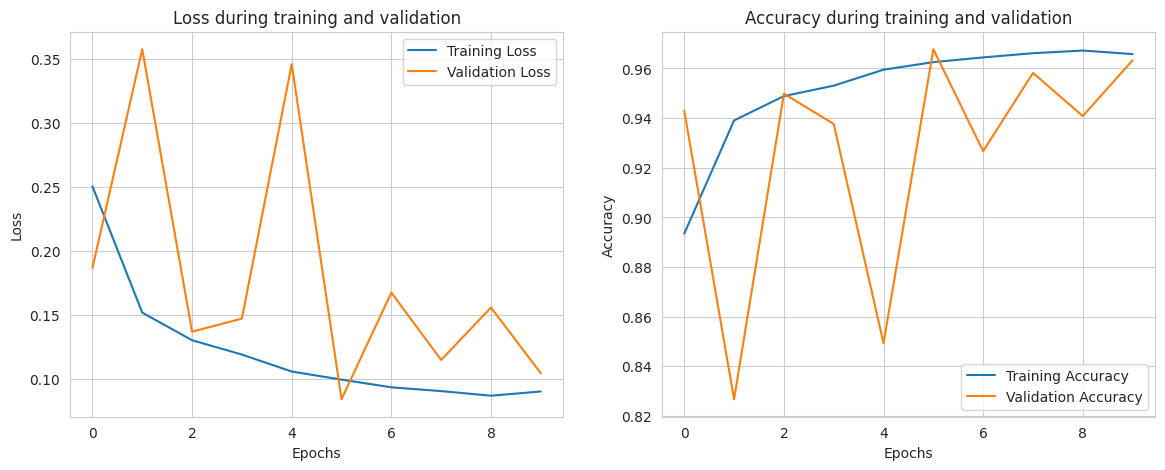

In [42]:
plt.figure(figsize=(14, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history_data['training_loss'], label='Training Loss')
plt.plot(history_data['val_loss'], label='Validation Loss')
plt.title('Loss during training and validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_data['training_accuracy'], label='Training Accuracy')
plt.plot(history_data['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy during training and validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [43]:
test_generator.reset()
test_predictions = model_Alex.predict(test_generator, steps=test_generator.samples // test_generator.batch_size)

binary_predictions = (test_predictions > 0.5).astype("int32").flatten()

test_labels = test_generator.classes[:len(binary_predictions)]

print("Classification Report:")
print(classification_report(test_labels, binary_predictions, target_names=list(test_generator.class_indices.keys())))

accuracy_value = accuracy(test_labels, binary_predictions)
precision_value = precision(test_labels, binary_predictions)
recall_value = recall(test_labels, binary_predictions)
f1_score_value = f1_score(test_labels, binary_predictions)

print("\nMetrics:")
print(f"Accuracy: {accuracy_value:.2f}%")
print(f"Precision: {precision_value:.2f}")
print(f"Recall: {recall_value:.2f}")
print(f"F1-Score: {f1_score_value:.2f}")

265/265 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step
Classification Report:
              precision    recall  f1-score   support

  Close-Eyes       0.96      0.98      0.97      4196
   Open-Eyes       0.98      0.96      0.97      4284

    accuracy                           0.97      8480
   macro avg       0.97      0.97      0.97      8480
weighted avg       0.97      0.97      0.97      8480


Metrics:
Accuracy: 96.76%
Precision: 0.98
Recall: 0.96
F1-Score: 0.97


## **VGG_NET**

In [44]:
def VGGNet(img_width=64, img_height=64):
    inp = layers.Input((img_width, img_height, 3))
    
    # Bloc 1
    x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(inp)
    x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    
    # Bloc 2
    x = layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    
    # Bloc 3
    x = layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    
    # Bloc 4
    x = layers.Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    
    # Bloc 5
    x = layers.Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    
    # Fully connected layers
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    # Couche de sortie (1 unité pour classification binaire)
    x = layers.Dense(1, activation='sigmoid')(x)
    
    # Création du modèle
    model_VGG = models.Model(inputs=inp, outputs=x)
    
    return model_VGG

# Création du modèle
model_VGG = VGGNet(img_width=64, img_height=64)
model_VGG.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 8, 8, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 39,898,689 (152.20 MB)

 Trainable params: 39,895,745 (152.19 MB)

 Non-trainable params: 2,944 (11.50 KB)

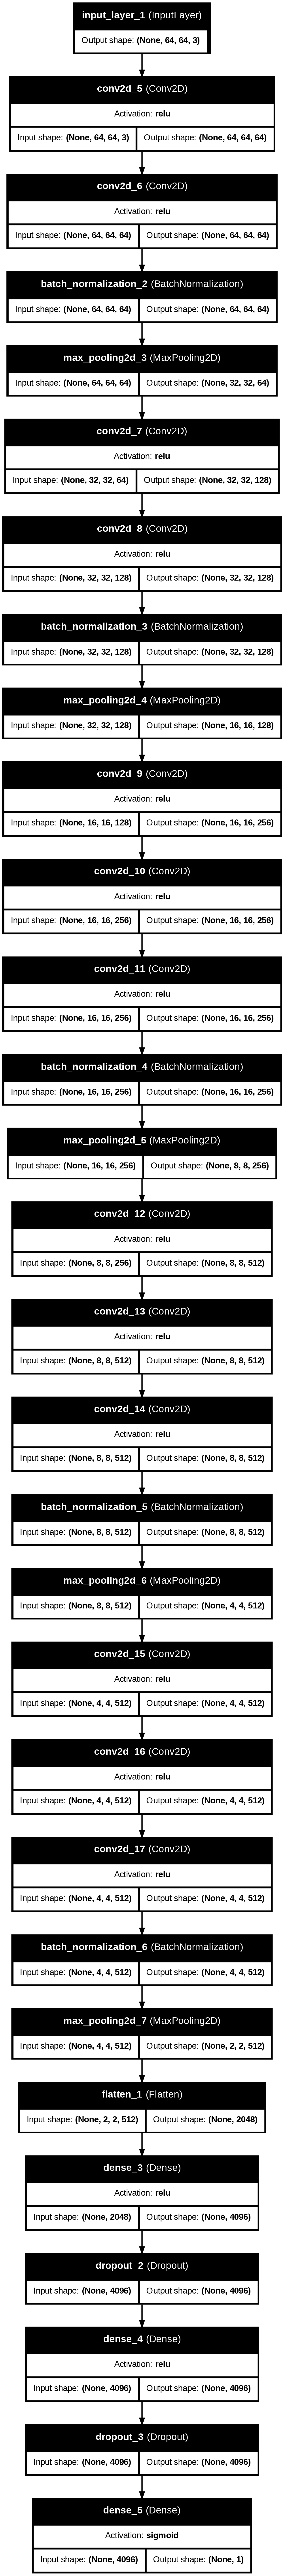

In [83]:
tf.keras.utils.plot_model(
    model_VGG,
    to_file='VGG_model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    show_layer_activations=True,
    dpi=200
)

In [46]:
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path_Vgg,
    save_weights_only=False,
    monitor="val_accuracy",
    save_best_only=True,
)

In [48]:
if __name__ == "__main__":


    model_VGG.compile(
        optimizer=Adam(0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    history_data = train_model(model_VGG, train_generator, val_generator, epochs=10)

Epoch 1/10
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 160s 90ms/step - accuracy: 0.8334 - loss: 0.4126 - val_accuracy: 0.8949 - val_loss: 0.2467 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 1.
Epoch 2/10
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 129s 81ms/step - accuracy: 0.9665 - loss: 0.0907 - val_accuracy: 0.9792 - val_loss: 0.0636 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 1.
Epoch 3/10
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 126s 79ms/step - accuracy: 0.9761 - loss: 0.0693 - val_accuracy: 0.9789 - val_loss: 0.0602 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 1.
Epoch 4/10
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 129s 81ms/step - accuracy: 0.9780 - loss: 0.0639 - val_accuracy: 0.9830 - val_loss: 0.0587 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 1.
Epoch 5/10
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 128s 80ms/step - accuracy: 0.9807 - loss: 0.0594 - val_accuracy: 0.9860 - val_

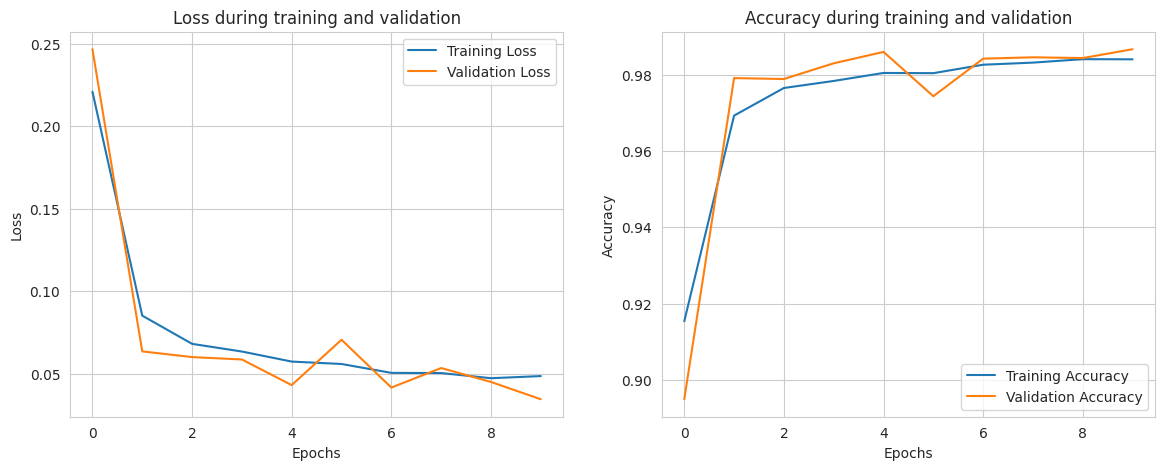

In [49]:
plt.figure(figsize=(14, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history_data['training_loss'], label='Training Loss')
plt.plot(history_data['val_loss'], label='Validation Loss')
plt.title('Loss during training and validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_data['training_accuracy'], label='Training Accuracy')
plt.plot(history_data['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy during training and validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [50]:
test_generator.reset()
test_predictions = model_VGG.predict(test_generator, steps=test_generator.samples // test_generator.batch_size)

binary_predictions = (test_predictions > 0.5).astype("int32").flatten()

test_labels = test_generator.classes[:len(binary_predictions)]

print("Classification Report:")
print(classification_report(test_labels, binary_predictions, target_names=list(test_generator.class_indices.keys())))

accuracy_value = accuracy(test_labels, binary_predictions)
precision_value = precision(test_labels, binary_predictions)
recall_value = recall(test_labels, binary_predictions)
f1_score_value = f1_score(test_labels, binary_predictions)

print("\nMetrics:")
print(f"Accuracy: {accuracy_value:.2f}%")
print(f"Precision: {precision_value:.2f}")
print(f"Recall: {recall_value:.2f}")
print(f"F1-Score: {f1_score_value:.2f}")

265/265 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
Classification Report:
              precision    recall  f1-score   support

  Close-Eyes       0.99      0.98      0.99      4196
   Open-Eyes       0.98      0.99      0.99      4284

    accuracy                           0.99      8480
   macro avg       0.99      0.99      0.99      8480
weighted avg       0.99      0.99      0.99      8480


Metrics:
Accuracy: 98.62%
Precision: 0.98
Recall: 0.99
F1-Score: 0.99


## **RESNET34**

In [51]:
def residual_block(x, filters, kernel_size=3, stride=1, conv_shortcut=True):
    """A residual block."""
    if conv_shortcut:
        shortcut = layers.Conv2D(filters, 1, stride, padding='same', kernel_initializer='he_normal')(x)
        shortcut = layers.BatchNormalization()(shortcut)
    else:
        shortcut = x

    x = layers.Conv2D(filters, kernel_size, stride, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, kernel_size, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)

    x = layers.add([shortcut, x])
    x = layers.ReLU()(x)
    return x

# Fonction pour construire le modèle ResNet34
def ResNet34_binary(img_width=64, img_height=64):
    inp = layers.Input((img_width, img_height, 3))
    x = layers.Conv2D(64, 7, 2, padding='same', activation='relu', kernel_initializer='he_normal')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # Blocs résiduels
    x = residual_block(x, 64, conv_shortcut=False)
    x = residual_block(x, 64)
    x = residual_block(x, 64)

    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128)
    x = residual_block(x, 128)
    x = residual_block(x, 128)

    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)

    x = residual_block(x, 512, stride=2)
    x = residual_block(x, 512)
    x = residual_block(x, 512)

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Fully connected layers
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    # Output layer for binary classification
    x = layers.Dense(1, activation='sigmoid')(x)

    # Final model
    model_Res = models.Model(inputs=inp, outputs=x)
    return model_Res

# Initialisation du modèle
model_ResNet = ResNet34_binary()
model_ResNet.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_18 (Conv2D)        │ (None, 32, 32, 64)     │          9,472 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 32, 32, 64)     │            256 │ conv2d_18[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 16, 16, 64)     │              0 │ batch_normalization_7… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 16, 16, 64)     │         36,928 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 16, 16, 64)     │            256 │ conv2d_19[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 16, 16, 64)     │              0 │ batch_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 16, 16, 64)     │         36,928 │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_9     │ (None, 16, 16, 64)     │            256 │ conv2d_20[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 16, 16, 64)     │              0 │ max_pooling2d_8[0][0], │
│                           │                        │                │ batch_normalization_9… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 16, 16, 64)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 16, 16, 64)     │         36,928 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_11    │ (None, 16, 16, 64)     │            256 │ conv2d_22[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 16, 16, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 16, 16, 64)     │          4,160 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 16, 16, 64)     │         36,928 │ re_lu_2[0][0]          │
├──────────────────────

 Total params: 22,627,841 (86.32 MB)

 Trainable params: 22,605,185 (86.23 MB)

 Non-trainable params: 22,656 (88.50 KB)

In [52]:
tf.keras.utils.plot_model(
    model_ResNet,
    to_file='ResNet_model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    show_layer_activations=True,
    dpi=200
)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.736519 to fit



In [53]:
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path_Res,
    save_weights_only=False,
    monitor="val_accuracy",
    save_best_only=True,
)

In [58]:
if __name__ == "__main__":


    model_ResNet.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    history_data = train_model(model_ResNet, train_generator, val_generator, epochs=10)

Epoch 1/10
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 171s 81ms/step - accuracy: 0.9806 - loss: 0.0545 - val_accuracy: 0.9845 - val_loss: 0.0428 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 1.
Epoch 2/10
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 111s 69ms/step - accuracy: 0.9824 - loss: 0.0494 - val_accuracy: 0.9810 - val_loss: 0.0554 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 1.
Epoch 3/10
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 110s 69ms/step - accuracy: 0.9822 - loss: 0.0488 - val_accuracy: 0.9775 - val_loss: 0.0539 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 1.
Epoch 4/10
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 110s 69ms/step - accuracy: 0.9828 - loss: 0.0495 - val_accuracy: 0.9850 - val_loss: 0.0402 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 1.
Epoch 5/10
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 110s 69ms/step - accuracy: 0.9808 - loss: 0.0583 - val_accuracy: 0.9859 - val_loss: 0.0388 - l

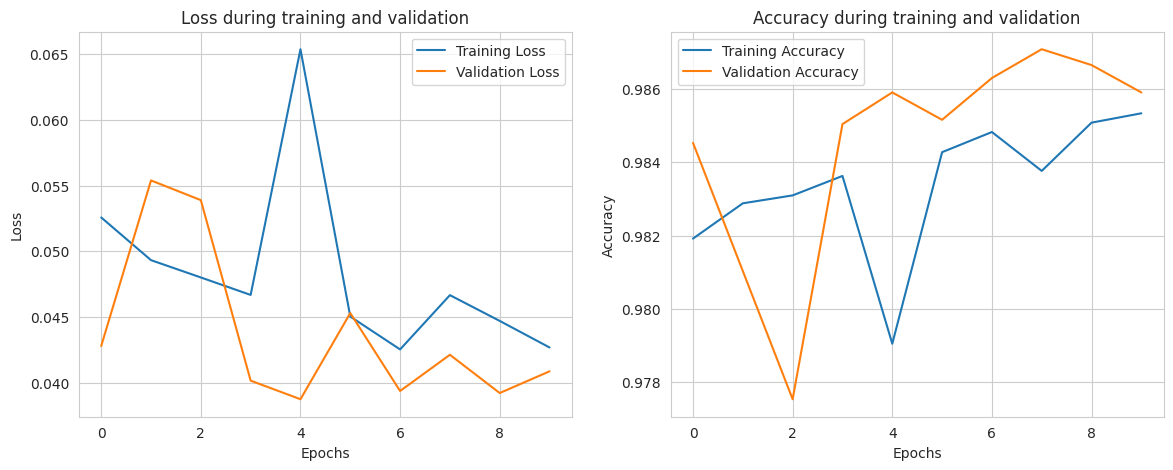

In [59]:
plt.figure(figsize=(14, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history_data['training_loss'], label='Training Loss')
plt.plot(history_data['val_loss'], label='Validation Loss')
plt.title('Loss during training and validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_data['training_accuracy'], label='Training Accuracy')
plt.plot(history_data['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy during training and validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [60]:
test_generator.reset()
test_predictions = model_ResNet.predict(test_generator, steps=test_generator.samples // test_generator.batch_size)

binary_predictions = (test_predictions > 0.5).astype("int32").flatten()

test_labels = test_generator.classes[:len(binary_predictions)]

print("Classification Report:")
print(classification_report(test_labels, binary_predictions, target_names=list(test_generator.class_indices.keys())))

accuracy_value = accuracy(test_labels, binary_predictions)
precision_value = precision(test_labels, binary_predictions)
recall_value = recall(test_labels, binary_predictions)
f1_score_value = f1_score(test_labels, binary_predictions)

print("\nMetrics:")
print(f"Accuracy: {accuracy_value:.2f}%")
print(f"Precision: {precision_value:.2f}")
print(f"Recall: {recall_value:.2f}")
print(f"F1-Score: {f1_score_value:.2f}")

265/265 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step
Classification Report:
              precision    recall  f1-score   support

  Close-Eyes       0.99      0.98      0.99      4196
   Open-Eyes       0.98      0.99      0.99      4284

    accuracy                           0.99      8480
   macro avg       0.99      0.99      0.99      8480
weighted avg       0.99      0.99      0.99      8480


Metrics:
Accuracy: 98.68%
Precision: 0.98
Recall: 0.99
F1-Score: 0.99


## **CNN parallel**

In [92]:
def cnn_parallel(img_width=64, img_height=64):
    inp = layers.Input(shape=(img_width, img_height, 3))
    
    # Branche 1 : CNN avec filtres 3x3
    cnn1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inp)
    cnn1 = layers.MaxPooling2D((2, 2))(cnn1)
    cnn1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(cnn1)
    cnn1 = layers.MaxPooling2D((2, 2))(cnn1)
    cnn1 = layers.Flatten()(cnn1)
    
    # Branche 2 : CNN avec filtres 5x5
    cnn2 = layers.Conv2D(32, (5, 5), activation='relu', padding='same')(inp)
    cnn2 = layers.MaxPooling2D((2, 2))(cnn2)
    cnn2 = layers.Conv2D(64, (5, 5), activation='relu', padding='same')(cnn2)
    cnn2 = layers.MaxPooling2D((2, 2))(cnn2)
    cnn2 = layers.Flatten()(cnn2)
    
    # Fusion des branches
    combined = layers.concatenate([cnn1, cnn2])
    
    # Fully connected layers
    combined = layers.Dense(128, activation='relu')(combined)
    combined = layers.Dropout(0.5)(combined)
    output_layer = layers.Dense(1, activation='sigmoid')(combined)
    
    
    model = models.Model(inputs=inp, outputs=output_layer)
    return model

model_cnn_parallel = cnn_parallel(img_width=64, img_height=64)
model_cnn_parallel.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_86 (Conv2D)        │ (None, 64, 64, 64)     │          1,792 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_90 (Conv2D)        │ (None, 64, 64, 64)     │          4,864 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_29          │ (None, 32, 32, 64)     │              0 │ conv2d_86[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_33          │ (None, 32, 32, 64)     │              0 │ conv2d_90[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_87 (Conv2D)        │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_29[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_91 (Conv2D)        │ (None, 32, 32, 128)    │        204,928 │ max_pooling2d_33[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_30          │ (None, 16, 16, 128)    │              0 │ conv2d_87[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_34          │ (None, 16, 16, 128)    │              0 │ conv2d_91[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_88 (Conv2D)        │ (None, 16, 16, 256)    │        295,168 │ max_pooling2d_30[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_92 (Conv2D)        │ (None, 16, 16, 256)    │        819,456 │ max_pooling2d_34[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_31          │ (None, 8, 8, 256)      │              0 │ conv2d_88[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_35          │ (None, 8, 8, 256)      │              0 │ conv2d_92[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_89 (Conv2D)        │ (None, 8, 8, 512)      │      1,180,160 │ max_pooling2d_31[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_93 (Conv2D)        │ (None, 8, 8, 512)      │      3,277,312 │ max_pooling2d_35[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_32          │ (None, 4, 4, 512)      │              0 │ conv2d_89[0][0]        │
│ (MaxPooling2D)       

 Total params: 77,166,849 (294.37 MB)

 Trainable params: 77,166,849 (294.37 MB)

 Non-trainable params: 0 (0.00 B)

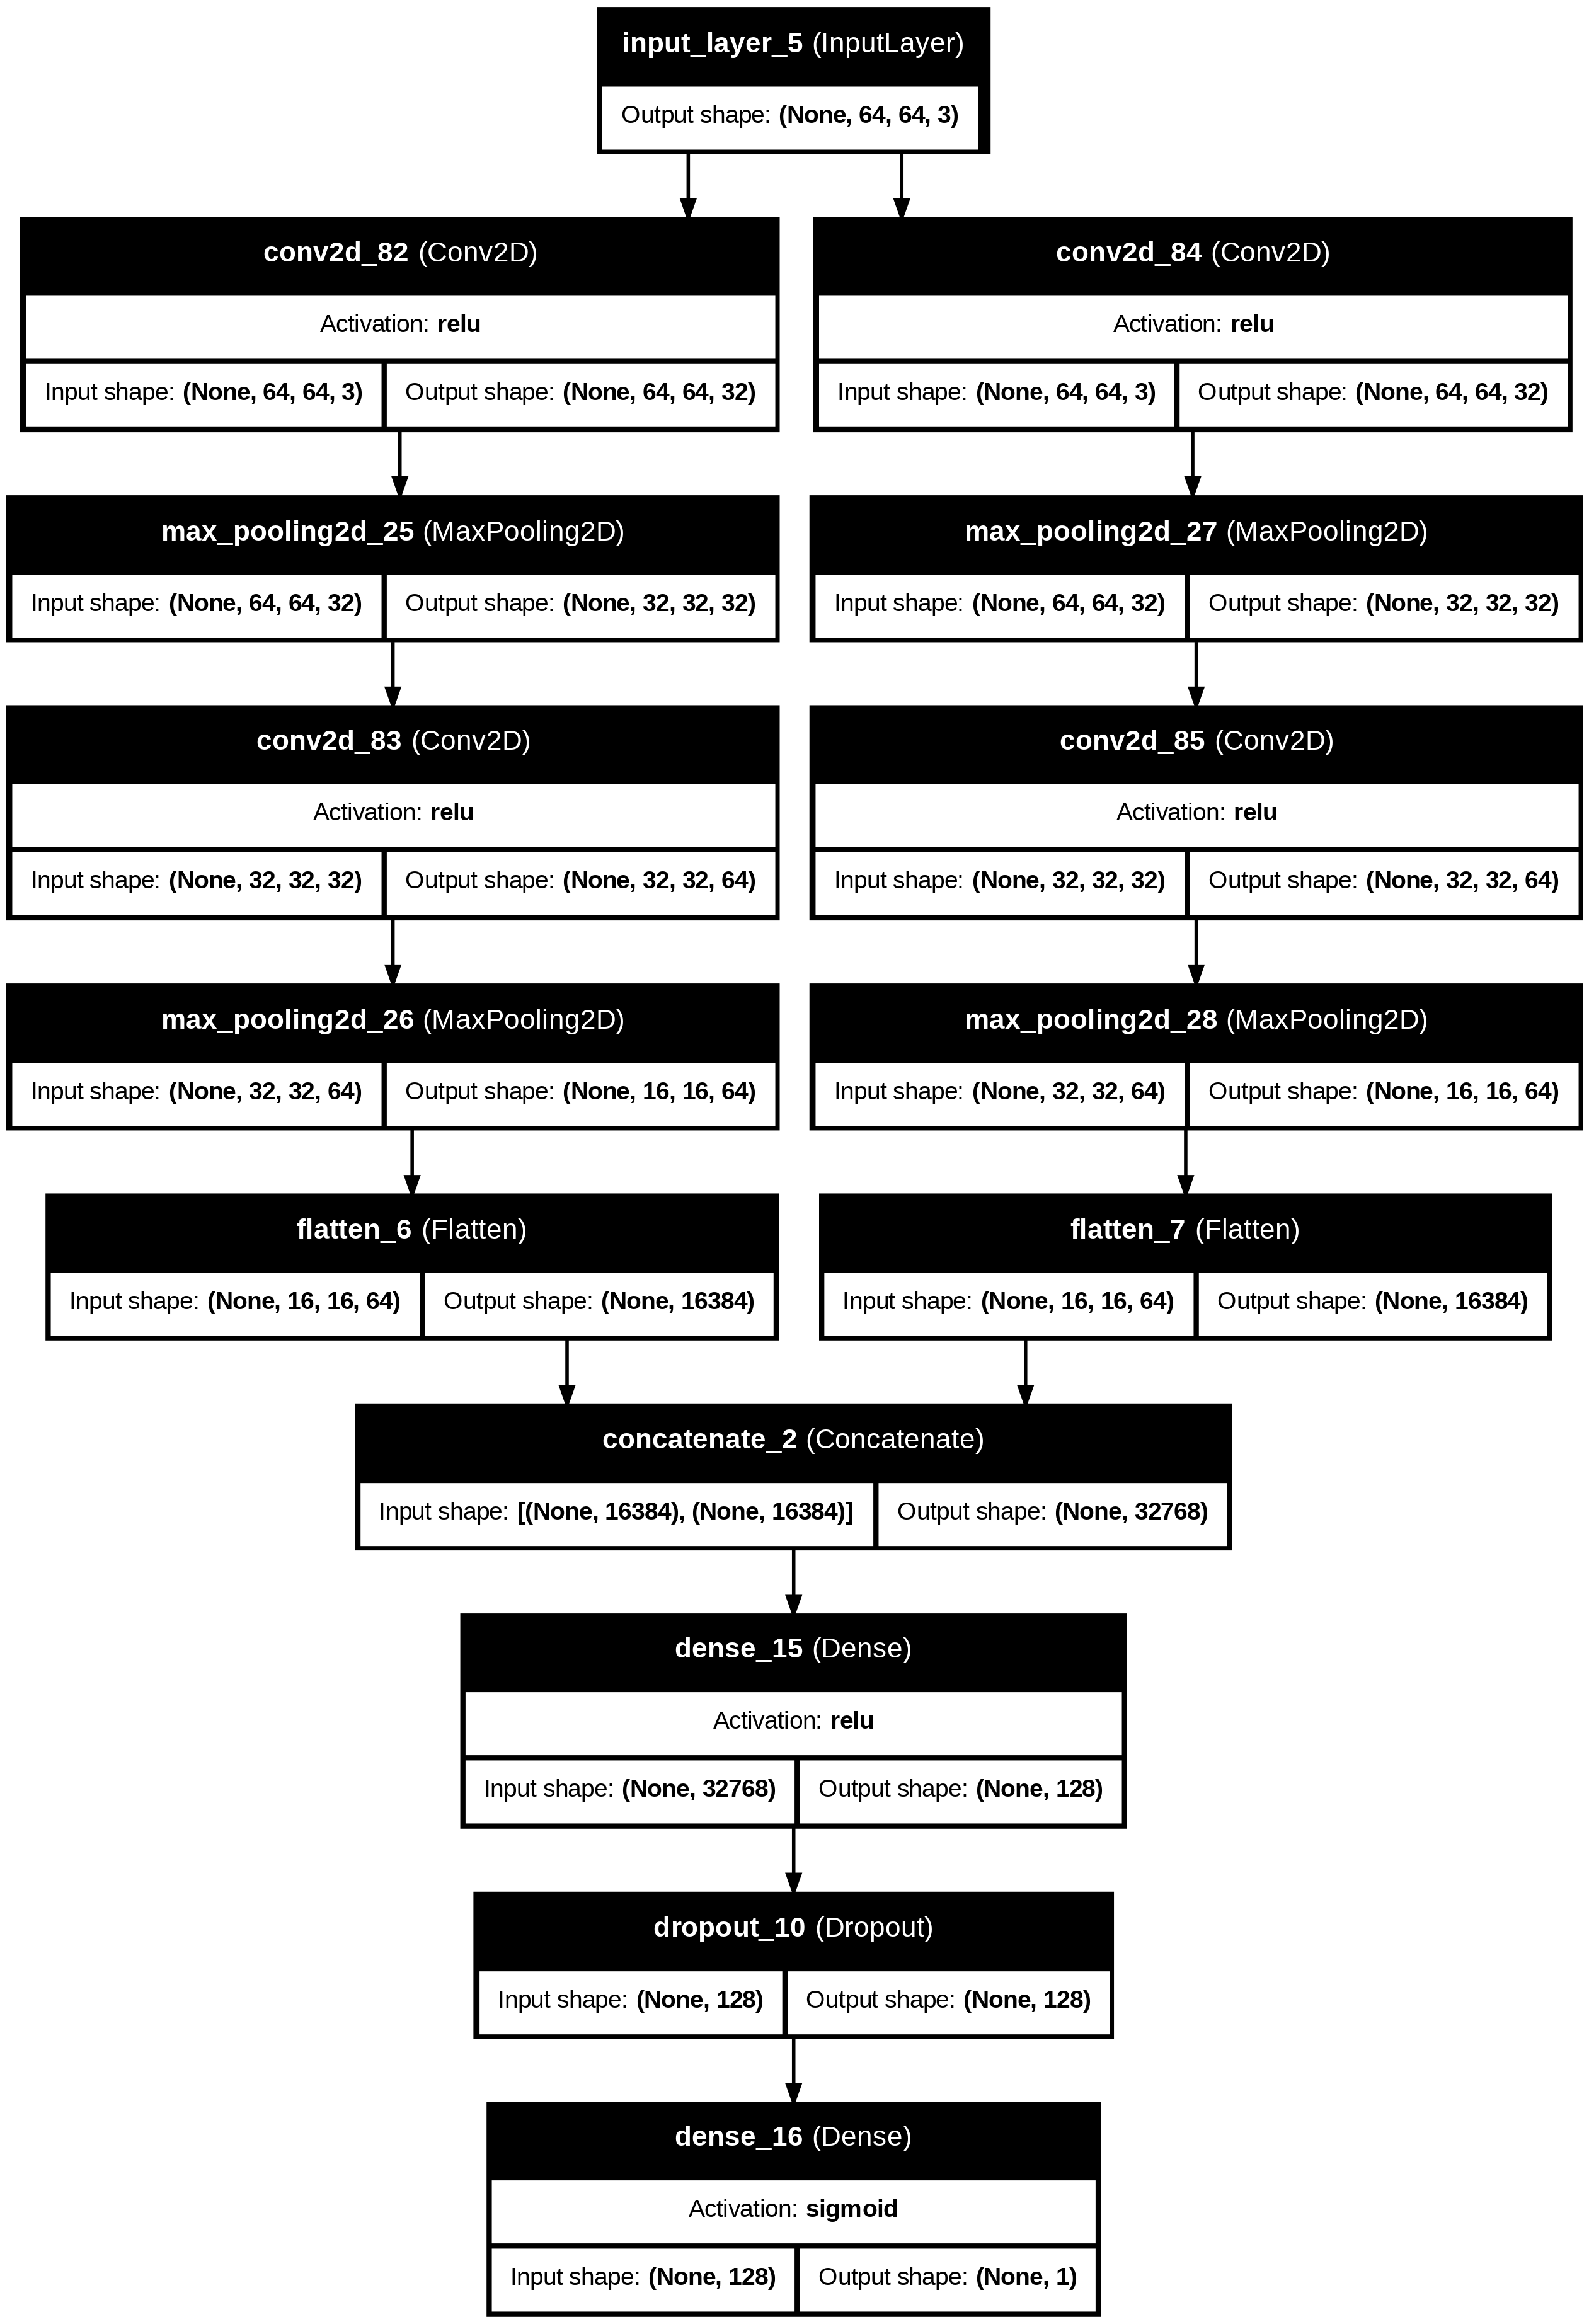

In [101]:
tf.keras.utils.plot_model(
    model_cnn_parallel,
    to_file='model_cnn_parallel.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    show_layer_activations=True,
    dpi=200
)

In [102]:
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path_CnnP,
    save_weights_only=False,
    monitor="val_accuracy",
    save_best_only=True,
)

In [104]:
if __name__ == "__main__":


    model_cnn_parallel.compile(
        optimizer=Adam(0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    history_data = train_model(model_cnn_parallel, train_generator, val_generator, epochs=10)

Epoch 1/10
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 106s 64ms/step - accuracy: 0.9639 - loss: 0.1027 - val_accuracy: 0.9807 - val_loss: 0.0582 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 1.
Epoch 2/10
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 100s 63ms/step - accuracy: 0.9646 - loss: 0.1000 - val_accuracy: 0.9801 - val_loss: 0.0566 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 1.
Epoch 3/10
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 101s 63ms/step - accuracy: 0.9675 - loss: 0.0945 - val_accuracy: 0.9810 - val_loss: 0.0539 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 1.
Epoch 4/10
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 102s 64ms/step - accuracy: 0.9671 - loss: 0.0939 - val_accuracy: 0.9834 - val_loss: 0.0513 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 1.
Epoch 5/10
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 100s 63ms/step - accuracy: 0.9657 - loss: 0.0962 - val_accuracy: 0.9825 - val_

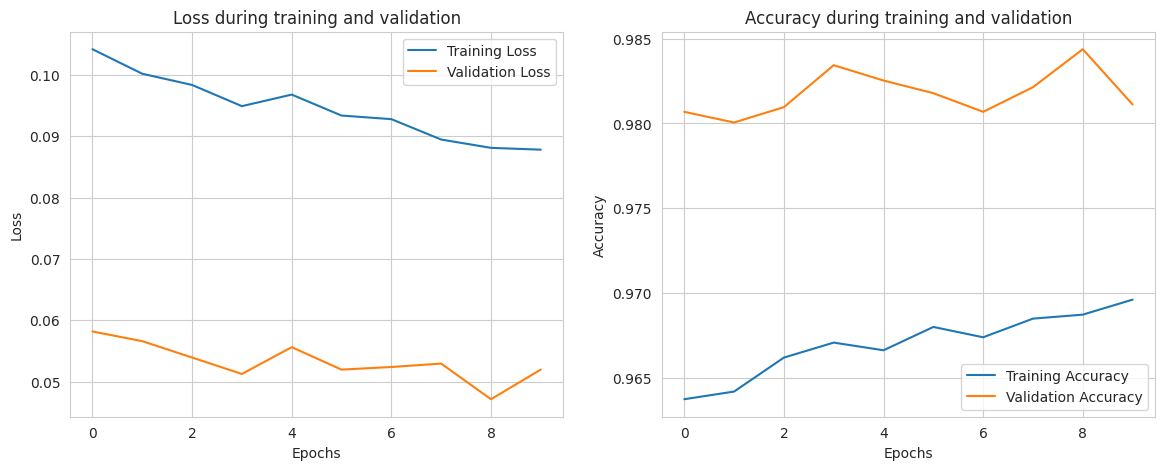

In [105]:
plt.figure(figsize=(14, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history_data['training_loss'], label='Training Loss')
plt.plot(history_data['val_loss'], label='Validation Loss')
plt.title('Loss during training and validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_data['training_accuracy'], label='Training Accuracy')
plt.plot(history_data['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy during training and validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [106]:
test_generator.reset()
test_predictions = model_cnn_parallel.predict(test_generator, steps=test_generator.samples // test_generator.batch_size)

binary_predictions = (test_predictions > 0.5).astype("int32").flatten()

test_labels = test_generator.classes[:len(binary_predictions)]

print("Classification Report:")
print(classification_report(test_labels, binary_predictions, target_names=list(test_generator.class_indices.keys())))

accuracy_value = accuracy(test_labels, binary_predictions)
precision_value = precision(test_labels, binary_predictions)
recall_value = recall(test_labels, binary_predictions)
f1_score_value = f1_score(test_labels, binary_predictions)

print("\nMetrics:")
print(f"Accuracy: {accuracy_value:.2f}%")
print(f"Precision: {precision_value:.2f}")
print(f"Recall: {recall_value:.2f}")
print(f"F1-Score: {f1_score_value:.2f}")

265/265 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
Classification Report:
              precision    recall  f1-score   support

  Close-Eyes       0.97      0.99      0.98      4196
   Open-Eyes       0.99      0.97      0.98      4284

    accuracy                           0.98      8480
   macro avg       0.98      0.98      0.98      8480
weighted avg       0.98      0.98      0.98      8480


Metrics:
Accuracy: 97.90%
Precision: 0.99
Recall: 0.97
F1-Score: 0.98
